In [1]:
import os, torch

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
# os.environ['NVIDIA_VISIBLE_DEVICES'] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [2]:
class Args():
    def __init__(self,cuda=True, trained_model='weights/craft_mlt_25k.pth', text_threshold=0.7, low_text=0.4, link_threshold=0.4, canvas_size =1100, mag_ratio=1.5, poly=False, show_time=False,test_folder='/data/',refine=False, refiner_model='weights/craft_refiner_CTW1500.pth'):
        self.cuda = cuda
        self.trained_model = trained_model = trained_model
        self.text_threshold = text_threshold
        self.low_text = low_text
        self.link_threshold = link_threshold
        self.canvas_size = canvas_size
        self.mag_ratio = mag_ratio
        self.poly = poly
        self.show_time = show_time
        self.test_folder = test_folder
        self.refine = refine
        self.refiner_model = refiner_model
        
def img_show(img, size =(15,15)):
    plt.rcParams["figure.figsize"] = size
    imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    

In [3]:
args = Args()

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import cv2
import math

""" auxilary functions """
# unwarp corodinates
def warpCoord(Minv, pt):
    out = np.matmul(Minv, (pt[0], pt[1], 1))
    return np.array([out[0]/out[2], out[1]/out[2]])
""" end of auxilary functions """


def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text):
    # prepare data
    linkmap = linkmap.copy()
    textmap = textmap.copy()
    img_h, img_w = textmap.shape
    """ labeling method """
    ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
    ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

    text_score_comb = np.clip(text_score + link_score, 0, 1)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

    det = []
    mapper = []
    for k in range(1,nLabels):
        # size filtering
        size = stats[k, cv2.CC_STAT_AREA]
        if size < 10: continue

        # thresholding
        if np.max(textmap[labels==k]) < text_threshold: continue

        # make segmentation map
        segmap = np.zeros(textmap.shape, dtype=np.uint8)
        segmap[labels==k] = 255
        segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area
        x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
        w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
        niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
        sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
        # boundary check
        if sx < 0 : sx = 0
        if sy < 0 : sy = 0
        if ex >= img_w: ex = img_w
        if ey >= img_h: ey = img_h
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
        segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

        # make box
        np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
        rectangle = cv2.minAreaRect(np_contours)
        box = cv2.boxPoints(rectangle)

        # align diamond-shape
        w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
        box_ratio = max(w, h) / (min(w, h) + 1e-5)
        if abs(1 - box_ratio) <= 0.1:
            l, r = min(np_contours[:,0]), max(np_contours[:,0])
            t, b = min(np_contours[:,1]), max(np_contours[:,1])
            box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

        # make clock-wise order
        startidx = box.sum(axis=1).argmin()
        box = np.roll(box, 4-startidx, 0)
        box = np.array(box)

        det.append(box)
        mapper.append(k)

    return det, labels, mapper

def getPoly_core(boxes, labels, mapper, linkmap):
    # configs
    num_cp = 5
    max_len_ratio = 0.7
    expand_ratio = 1.45
    max_r = 2.0
    step_r = 0.2

    polys = []  
    for k, box in enumerate(boxes):
        # size filter for small instance
        w, h = int(np.linalg.norm(box[0] - box[1]) + 1), int(np.linalg.norm(box[1] - box[2]) + 1)
        if w < 10 or h < 10:
            polys.append(None); continue

        # warp image
        tar = np.float32([[0,0],[w,0],[w,h],[0,h]])
        M = cv2.getPerspectiveTransform(box, tar)
        word_label = cv2.warpPerspective(labels, M, (w, h), flags=cv2.INTER_NEAREST)
        try:
            Minv = np.linalg.inv(M)
        except:
            polys.append(None); continue

        # binarization for selected label
        cur_label = mapper[k]
        word_label[word_label != cur_label] = 0
        word_label[word_label > 0] = 1

        """ Polygon generation """
        # find top/bottom contours
        cp = []
        max_len = -1
        for i in range(w):
            region = np.where(word_label[:,i] != 0)[0]
            if len(region) < 2 : continue
            cp.append((i, region[0], region[-1]))
            length = region[-1] - region[0] + 1
            if length > max_len: max_len = length

        # pass if max_len is similar to h
        if h * max_len_ratio < max_len:
            polys.append(None); continue

        # get pivot points with fixed length
        tot_seg = num_cp * 2 + 1
        seg_w = w / tot_seg     # segment width
        pp = [None] * num_cp    # init pivot points
        cp_section = [[0, 0]] * tot_seg
        seg_height = [0] * num_cp
        seg_num = 0
        num_sec = 0
        prev_h = -1
        for i in range(0,len(cp)):
            (x, sy, ey) = cp[i]
            if (seg_num + 1) * seg_w <= x and seg_num <= tot_seg:
                # average previous segment
                if num_sec == 0: break
                cp_section[seg_num] = [cp_section[seg_num][0] / num_sec, cp_section[seg_num][1] / num_sec]
                num_sec = 0

                # reset variables
                seg_num += 1
                prev_h = -1

            # accumulate center points
            cy = (sy + ey) * 0.5
            cur_h = ey - sy + 1
            cp_section[seg_num] = [cp_section[seg_num][0] + x, cp_section[seg_num][1] + cy]
            num_sec += 1

            if seg_num % 2 == 0: continue # No polygon area

            if prev_h < cur_h:
                pp[int((seg_num - 1)/2)] = (x, cy)
                seg_height[int((seg_num - 1)/2)] = cur_h
                prev_h = cur_h

        # processing last segment
        if num_sec != 0:
            cp_section[-1] = [cp_section[-1][0] / num_sec, cp_section[-1][1] / num_sec]

        # pass if num of pivots is not sufficient or segment widh is smaller than character height 
        if None in pp or seg_w < np.max(seg_height) * 0.25:
            polys.append(None); continue

        # calc median maximum of pivot points
        half_char_h = np.median(seg_height) * expand_ratio / 2

        # calc gradiant and apply to make horizontal pivots
        new_pp = []
        for i, (x, cy) in enumerate(pp):
            dx = cp_section[i * 2 + 2][0] - cp_section[i * 2][0]
            dy = cp_section[i * 2 + 2][1] - cp_section[i * 2][1]
            if dx == 0:     # gradient if zero
                new_pp.append([x, cy - half_char_h, x, cy + half_char_h])
                continue
            rad = - math.atan2(dy, dx)
            c, s = half_char_h * math.cos(rad), half_char_h * math.sin(rad)
            new_pp.append([x - s, cy - c, x + s, cy + c])

        # get edge points to cover character heatmaps
        isSppFound, isEppFound = False, False
        grad_s = (pp[1][1] - pp[0][1]) / (pp[1][0] - pp[0][0]) + (pp[2][1] - pp[1][1]) / (pp[2][0] - pp[1][0])
        grad_e = (pp[-2][1] - pp[-1][1]) / (pp[-2][0] - pp[-1][0]) + (pp[-3][1] - pp[-2][1]) / (pp[-3][0] - pp[-2][0])
        for r in np.arange(0.5, max_r, step_r):
            dx = 2 * half_char_h * r
            if not isSppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_s * dx
                p = np.array(new_pp[0]) - np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    spp = p
                    isSppFound = True
            if not isEppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_e * dx
                p = np.array(new_pp[-1]) + np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    epp = p
                    isEppFound = True
            if isSppFound and isEppFound:
                break

        # pass if boundary of polygon is not found
        if not (isSppFound and isEppFound):
            polys.append(None); continue

        # make final polygon
        poly = []
        poly.append(warpCoord(Minv, (spp[0], spp[1])))
        for p in new_pp:
            poly.append(warpCoord(Minv, (p[0], p[1])))
        poly.append(warpCoord(Minv, (epp[0], epp[1])))
        poly.append(warpCoord(Minv, (epp[2], epp[3])))
        for p in reversed(new_pp):
            poly.append(warpCoord(Minv, (p[2], p[3])))
        poly.append(warpCoord(Minv, (spp[2], spp[3])))

        # add to final result
        polys.append(np.array(poly))

    return polys

def getDetBoxes(textmap, linkmap, text_threshold, link_threshold, low_text, poly=False):
    
    boxes, labels, mapper = getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text)

    if poly:
        polys = getPoly_core(boxes, labels, mapper, linkmap)
    else:
        polys = [None] * len(boxes)

    return boxes, polys

def adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net = 2):
    if len(polys) > 0:
        polys = np.array(polys)
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

In [5]:
import sys
import os
import time
import argparse
from pathlib import Path
from glob import glob

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
# import craft_utils
import imgproc
import file_utils
import json
import zipfile

from collections import OrderedDict

from torch.autograd import Variable

import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

from icecream import ic
import matplotlib.pyplot as plt

TRT_LOGGER = trt.Logger()

class RTLayer():
    
    """
    
    """

    def __init__(self, config=None, model_path=None, data_path='./weights',
                 engine_path=None, cuda_ctx=None, input_shape=None):
        super().__init__()
        data_path = os.path.abspath(data_path)
        model_path = sorted(glob(data_path + '/*.engine'))
    
#         self.engine_path=model_path[0]
        self.engine_path=data_path+'/detec_trt2.engine'
        
        self.cuda_ctx = cuda_ctx
        if self.cuda_ctx:
            self.cuda_ctx.push()

        self.trt_logger = trt.Logger(trt.Logger.INFO)
        self._load_plugins()
        self.engine = self._load_engine()
        self.input_shape = input_shape

    def __call__(self, args, image, arg_cuda):
        
        trt_infer_befo_mem = torch.cuda.memory_allocated()/1024/1024
        print("current_memory:", trt_infer_befo_mem)
        

        # resize
        img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
        ratio_h = ratio_w = 1 / target_ratio
        
#         t0 = time.time()
        # preprocessing
        img_resized = imgproc.normalizeMeanVariance(img_resized)
        img_resized = torch.from_numpy(img_resized).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
        img_resized = Variable(img_resized.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
#         t0 = time.time() - t0
#         print(t0)
        t0 = time.time()
#         if arg_cuda:
#             img_resized.cuda()
#             img_resized = img_resized.to(device)
        t0 = time.time() - t0
        print(t0)
        # ic(img_resized.shape)
        
        # feed to engine and process output
        height, width = img_resized.shape[2:4]
        self.input_shape = (height,width)
        img_resized = img_resized.cpu().detach().numpy()
#         print('img2', img_resized.shape, img_resized)
    
        segment_inputs, segment_outputs, segment_bindings = self._allocate_buffers()
        
        stream = cuda.Stream()
        
        with self.engine.create_execution_context() as context:
            context.active_optimization_profile = 0
            origin_inputshape=context.get_binding_shape(0)
            
            if (origin_inputshape[-1]==-1):
                origin_inputshape[-2],origin_inputshape[-1]=(self.input_shape)
                context.set_binding_shape(0,(origin_inputshape))
            
            input_img_array = np.array([img_resized] * self.engine.max_batch_size)
            img = torch.from_numpy(input_img_array).float().numpy()
#             input_img_array = [img_resized] * self.engine.max_batch_size
            segment_inputs[0].host = img
#             segment_inputs[0].host = input_img_array
            [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in segment_inputs] #Copy from the Python buffer src to the device pointer dest (an int or a DeviceAllocation) asynchronously,
#             segment_inputs[0].device
            stream.synchronize() #Wait for all activity on this stream to cease, then return.
            
            context.execute_async_v2(bindings=segment_bindings, stream_handle=stream.handle)#Asynchronously execute inference on a batch. 
            
            stream.synchronize()
            [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in segment_outputs]#Copy from the device pointer src (an int or a DeviceAllocation) to the Python buffer dest asynchronously
            stream.synchronize()
            bs = context.get_binding_shape(2)

            y_out = segment_outputs[0].host
        
        t1 = time.time()
        y1 =  y_out[0:np.array(bs).prod()].reshape(bs)
#         ic('head: ',y_out[0:np.array(bs).prod()])
#         ic('tail: ',y_out[np.array(bs).prod():])
        
        y = torch.from_numpy(y1)
#         ic(5,'y2: ',y.shape)
#         ic('value: ',y)
        
        # make score and link map
        score_text = y[0,:,:,0].cpu().data.numpy()
        score_link = y[0,:,:,1].cpu().data.numpy()
        img_show(score_text)
        img_show(score_link)
        # refine link
        if refine_net is not None:
            with torch.no_grad():
                y_refiner = refine_net(y, feature)
            score_link = y_refiner[0,:,:,0].cpu().data.numpy()

        t1 = time.time() - t1
        print(t1)
        # Post-processing
        boxes, polys = getDetBoxes(score_text, score_link, args.text_threshold, args.link_threshold, args.low_text, args.poly)

        # coordinate adjustment
        boxes = adjustResultCoordinates(boxes, ratio_w, ratio_h)
        polys = adjustResultCoordinates(polys, ratio_w, ratio_h)
        for k in range(len(polys)):
            if polys[k] is None: polys[k] = boxes[k]

        # render results (optional)
        render_img = score_text.copy()
        render_img = np.hstack((render_img, score_link))
        ret_score_text = imgproc.cvt2HeatmapImg(render_img)
        
#         print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))
        
        trt_infer_mem = torch.cuda.memory_allocated()/1024/1024
        print("trt infer memory: %fMB"%(trt_infer_mem-trt_infer_befo_mem))
        
        return boxes, polys, ret_score_text
        
    def _load_plugins(self):
        if trt.__version__[0] < '7':
            ctypes.CDLL("./libflattenconcat.so")
        trt.init_libnvinfer_plugins(self.trt_logger, '')
        print('success load pluginx')
    def _load_engine(self):
        assert os.path.exists(self.engine_path)
        print("Reading engine from file {}".format(self.engine_path))
        with open(self.engine_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
            print('success load engine')
            return runtime.deserialize_cuda_engine(f.read())

    def _allocate_buffers(self):
        inputs = []
        outputs = []
        bindings = []
        class HostDeviceMem(object):
            def __init__(self, host_mem, device_mem):
                self.host = host_mem
                self.device = device_mem

            def __str__(self):
                return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)
            
            def __repr__(self):
                return self.__str__()
        for binding in self.engine:
            
            dims = self.engine.get_binding_shape(binding)
            # print(dims)
            if dims[-1] == -1:
                assert(self.input_shape is not None)
                dims[-2],dims[-1] = self.input_shape
            size = trt.volume(dims) * self.engine.max_batch_size#The maximum batch size which can be used for inference.
            
            dtype = trt.nptype(self.engine.get_binding_dtype(binding))
            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            # Append the device buffer to device bindings.
            bindings.append(int(device_mem))
            if self.engine.binding_is_input(binding):#Determine whether a binding is an input binding.
                inputs.append(HostDeviceMem(host_mem, device_mem))
            else:
                outputs.append(HostDeviceMem(host_mem, device_mem))
        print('success allocate_buffers')
        return inputs, outputs, bindings

    # def __del__(self):
    #     """Free CUDA memories and context."""
    #     del self.cuda_outputs
    #     del self.cuda_inputs
    #     del self.stream

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
_____________________________________________________________________________
This file contains main inference pipeline to Tensor RT
_____________________________________________________________________________
"""
from icecream import ic
import os
import time
import argparse

from PIL import Image

import cv2
from skimage import io
import imgproc
import file_utils

# from trt_layer import RTLayer

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

# parser = argparse.ArgumentParser(description='TensorRT inference pipeline for CRAFT Text Detection')
# parser.add_argument('--text_threshold', default=0.7, type=float, help='text confidence threshold')
# parser.add_argument('--low_text', default=0.4, type=float, help='text low-bound score')
# parser.add_argument('--link_threshold', default=0.4, type=float, help='link confidence threshold')
# parser.add_argument('--canvas_size', default=1100, type=int, help='image size for inference')
# parser.add_argument('--mag_ratio', default=1.5, type=float, help='image magnification ratio')
# parser.add_argument('--poly', default=False, action='store_true', help='enable polygon type')
# parser.add_argument('--show_time', default=False, action='store_true', help='show processing time')
# parser.add_argument('--test_folder', default='images/', type=str, help='folder path to input images')

# args = parser.parse_args()

""" For test images in a folder """

result_folder = './result/'
if not os.path.isdir(result_folder):
    os.mkdir(result_folder)

def test_net(args, image):
    layer = RTLayer()
    t = time.time()
    boxes, polys, ret_score_text = layer(args, image)
    print(f'infer time: {time.time()-t}')
    return boxes, polys, ret_score_text


In [7]:
trt_load_befo_mem = torch.cuda.memory_allocated()/1024/1024
print("current_memory:", trt_load_befo_mem)
t2 = time.time()
layer = RTLayer()
print(f'load time: {time.time()-t2}')

trt_load_mem = torch.cuda.memory_allocated()/1024/1024

print("trt_load_mem: %fMB"%(trt_load_mem-trt_load_befo_mem))

current_memory: 0.0
success load pluginx
Reading engine from file /workspace/DBP/NAS저장공간/hengbee/ONNX-TensorRT-Inference-CRAFT-pytorch/weights/detec_trt2.engine
success load engine
load time: 17.959935903549194
trt_load_mem: 0.000000MB


In [8]:
# LinkRefiner
refine_net = None
if args.refine:
    from refinenet import RefineNet
    refine_net = RefineNet()
    print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')
    if args.cuda:
        refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
        refine_net = refine_net.cuda()
        refine_net = torch.nn.DataParallel(refine_net)
    else:
        refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

    refine_net.eval()
    args.poly = True

In [9]:
import imgproc
import cv2
from torch.autograd import Variable

image_path = './IMG_8178.jpg'
print("Test image :", image_path)

image = imgproc.loadImage(image_path)

Test image : ./IMG_8178.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current_memory: 0.0
2.384185791015625e-07
success allocate_buffers


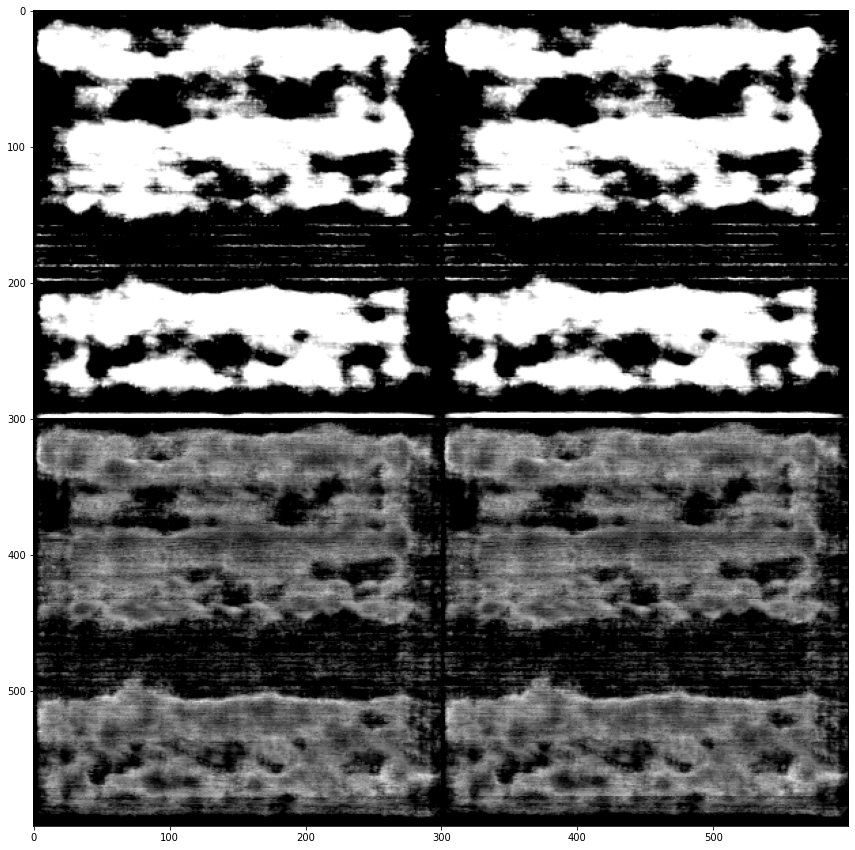

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


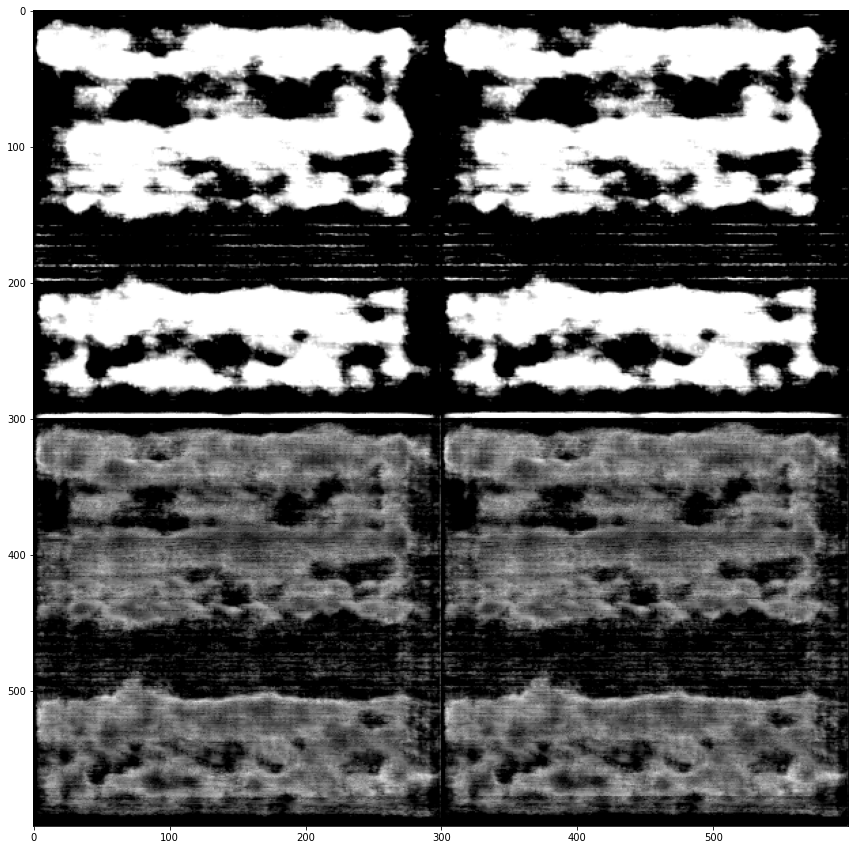

0.8810000419616699
trt infer memory: 0.000000MB
trt infer time: 1.4448862075805664


In [10]:
t1 = time.time()
boxes, polys, ret_score_text = layer(args, image, args.cuda)
print(f'trt infer time: {time.time()-t1}')

current_memory: 0.0
2.384185791015625e-07
success allocate_buffers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


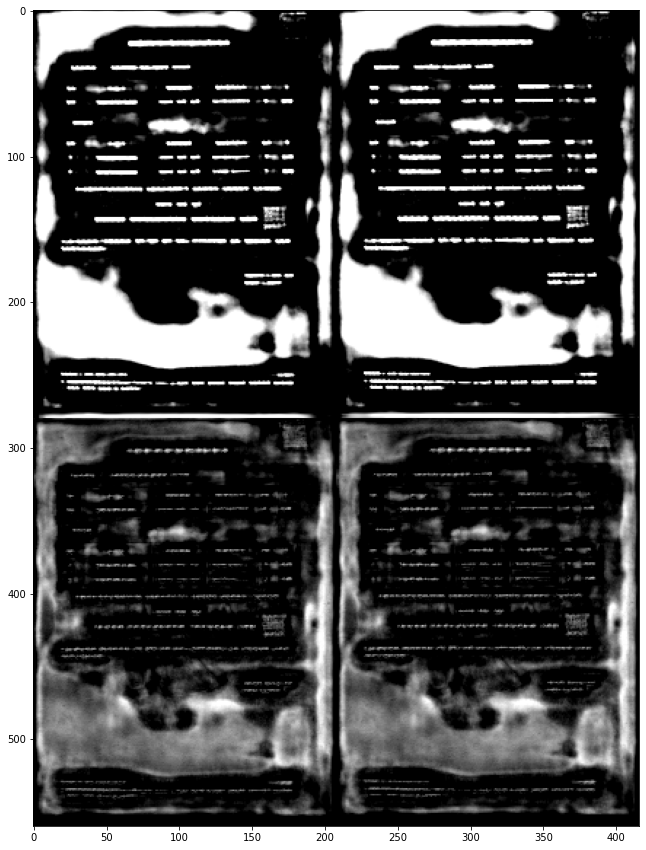

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


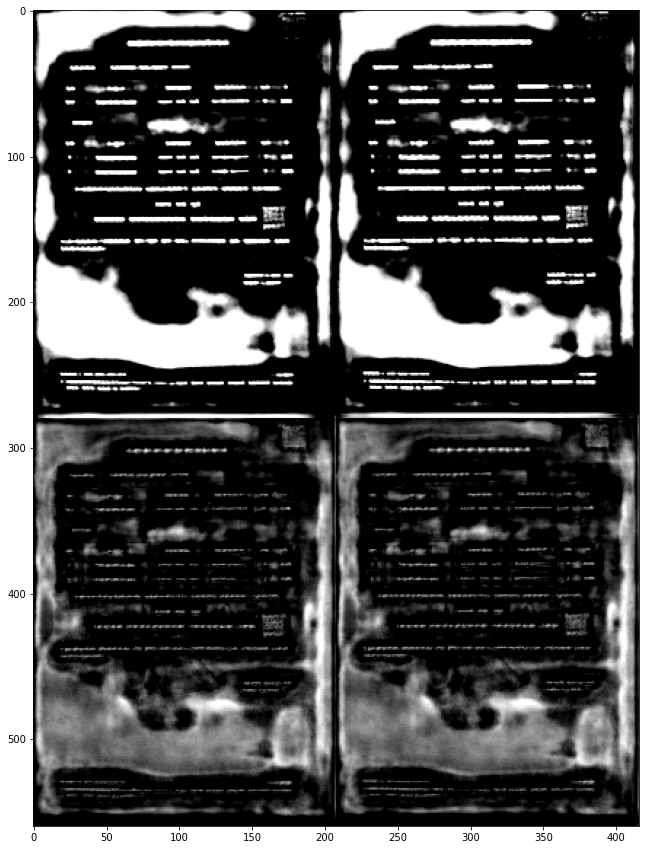

0.690331220626831
trt infer memory: 0.000000MB
trt infer time: 1.1997275352478027


In [20]:
t1 = time.time()
boxes, polys, ret_score_text = layer(args, image, args.cuda)
print(f'trt infer time: {time.time()-t1}')

In [11]:
boxes.shape

(49, 4, 2)

In [13]:
t1 = time.time()
boxes, polys, ret_score_text = layer(args, image, args.cuda)
print(f'trt infer time: {time.time()-t1}')

current_memory: 0.0
0.0
success allocate_buffers
0.0003380775451660156
trt infer memory: 0.000000MB
trt infer time: 0.32146668434143066


In [10]:
t1 = time.time()
boxes, polys, ret_score_text = layer(args, image, args.cuda)

print(f'trt infer time: {time.time()-t1}')

current_memory: 0.0
2.384185791015625e-07
success allocate_buffers
0.0003936290740966797
trt infer memory: 0.000000MB
trt infer time: 0.199082612991333


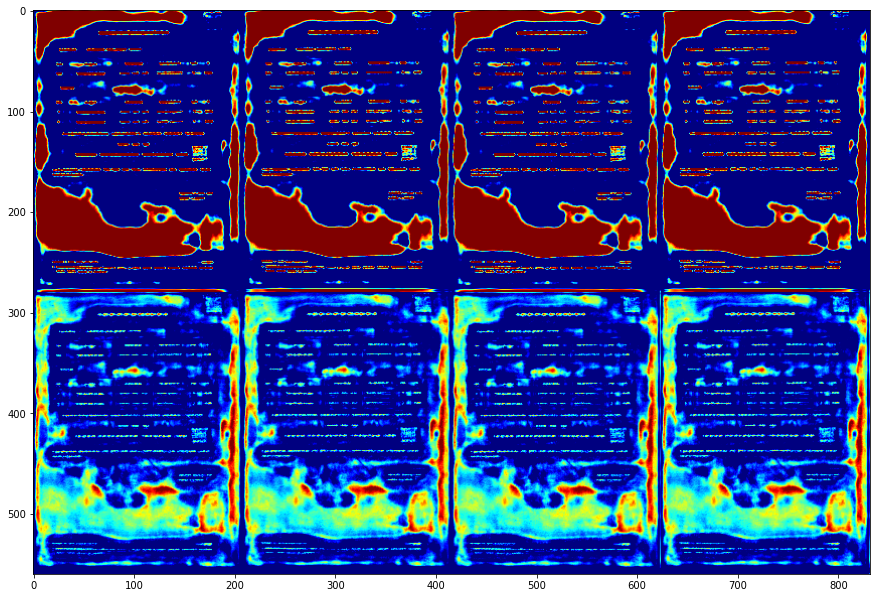

In [12]:
img_show(ret_score_text)

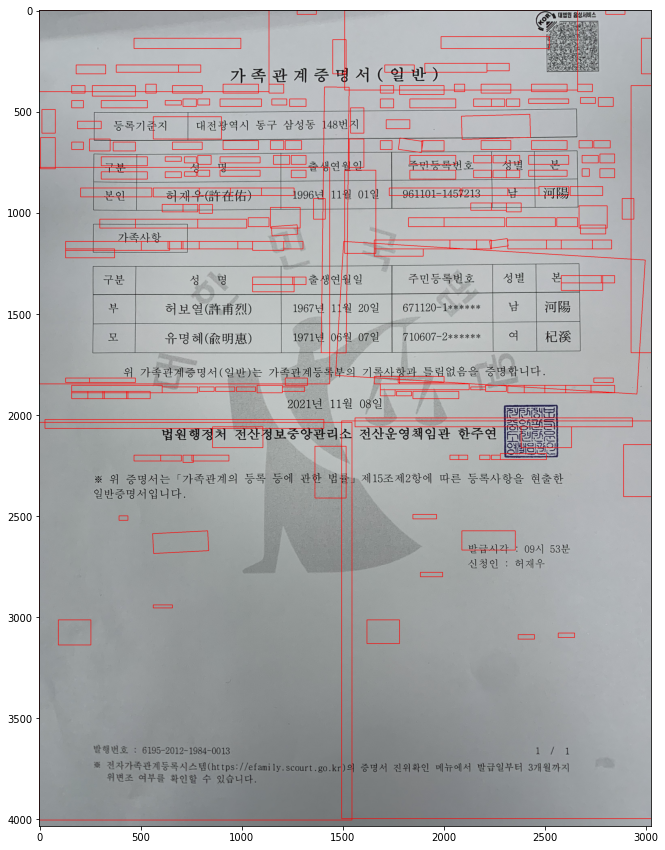

In [14]:
# for idx,i in enumerate(image_boxes):
img_1 = image.copy()
imageWidth, imageHeight = img_1.shape[:2] 
resizeHeight = int(1 * imageHeight) 
resizeWidth = int(1 * imageWidth) 
resizeImageNDArray = cv2.resize(img_1, (resizeHeight, resizeWidth), interpolation = cv2.INTER_CUBIC)

for pts in boxes:

    pts = np.array(pts).reshape(-1,2).astype(np.int32)

    resizeImageNDArray = cv2.polylines(resizeImageNDArray, [pts], True, (0,0,255),2)

img_show(resizeImageNDArray)

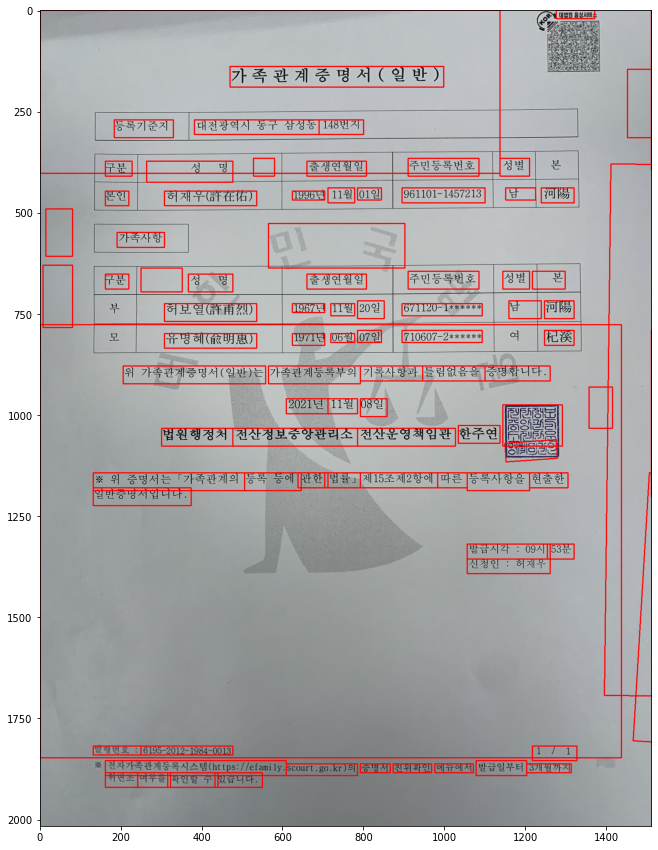

In [11]:
# for idx,i in enumerate(image_boxes):
img_1 = image.copy()
imageWidth, imageHeight = img_1.shape[:2] 
resizeHeight = int(0.5 * imageHeight) 
resizeWidth = int(0.5 * imageWidth) 
resizeImageNDArray = cv2.resize(img_1, (resizeHeight, resizeWidth), interpolation = cv2.INTER_CUBIC)

for pts in boxes:

    pts = np.array(pts).reshape(-1,2).astype(np.int32)

    resizeImageNDArray = cv2.polylines(resizeImageNDArray, [pts], True, (0,0,255),2)

img_show(resizeImageNDArray)

In [ ]:
bboxes.shape

In [ ]:
img_1 = image.copy()

for pts in bboxes:

    pts = np.array(pts).reshape(-1,2).astype(np.int32)

    img_1 = cv2.polylines(img_1, [pts], True, (0,0,255),2)

img_show(img_1)